# Neural Networks
Neural networks is basically compromise of multiple layers of logistic regressions. The first layer is the features. The last layer is the probabilities of each labels. One big advantage I see here is we do not need to do the feature mapping (for example, polynomial operation) for high nonlinear classification problems.

**Loss function**: one sample

**Cost function**: mean sum of all the samples

**Activation function**:

**Input layer**:

**Hidden layer**:

**Output layer**:


Let us build our own code to implement a neural network with one hidden layer from the basement using a generated planar dataset.

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neural_network import MLPClassifier
import tensorflow as tf

X,y = make_moons(n_samples=500,noise=0.2,random_state=1)

idx_class1 = y==0;
idx_class2 = y==1;

y = y.reshape(-1,1).T
X = X.T

X1 = X[0,:].reshape(1,-1)
X2 = X[1,:].reshape(1,-1)

X1_test,X2_test = np.meshgrid(np.linspace(X1.min()-0.2,X1.max()+0.2,100),np.linspace(X2.min()-0.2,X2.max()+0.2,100))
X_test = np.vstack((X1_test.flatten(),X2_test.flatten()))

In [3]:
def initialize_parameters(layer_dims,verbose=False):
    
    if verbose:
        print("parameter dimensions")
        
    np.random.seed(0)
    
    parameters = {}
    n_layer = len(layer_dims)
    parameters['nlayer'] = n_layer
    
    for i in np.arange(1,n_layer):
        W = np.random.randn(layer_dims[i],layer_dims[i-1])*0.01
        b = np.zeros((layer_dims[i],1))
        parameters['W'+str(i)] = W
        parameters['b'+str(i)] = b
        
        if verbose:
            print("W{}: [{},{}]   b{}: [{},{}]".format(i,W.shape[0],W.shape[1],i,b.shape[0],b.shape[1]))
    return parameters  

parameters = initialize_parameters([2,4,1],verbose=True)
print(parameters)

parameter dimensions
W1: [4,2]   b1: [4,1]
W2: [1,4]   b2: [1,1]
{'nlayer': 3, 'W1': array([[ 0.01764052,  0.00400157],
       [ 0.00978738,  0.02240893],
       [ 0.01867558, -0.00977278],
       [ 0.00950088, -0.00151357]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[-0.00103219,  0.00410599,  0.00144044,  0.01454274]]), 'b2': array([[0.]])}


**Forward propagation**

Vectorization:

In [4]:
def linear(X,w,b):
    z = np.dot(w,X) + b
    return z

def sigmoid(Z):
    g = 1/(1+np.exp(-Z))
    return g

def relu(Z):
    g = np.maximum(Z,0)
    return g

def foward_probagation(X,parameters,verbose=False):
    if verbose:
        print('activation dimensions')
    n_layer = parameters['nlayer']
    
    caches = {}
    caches['A0'] = X
    if verbose:
        print("A{}: [{},{}]".format(0,X.shape[0],X.shape[1]))
    
    for i in range(1,n_layer-1,1):
        Z = linear(caches['A'+str(i-1)],parameters['W'+str(i)],parameters['b'+str(i)])
        A = relu(Z)
        caches['A'+str(i)] = A
        
        if verbose:
            print("A{}: [{},{}]".format(i,A.shape[0],A.shape[1]))
        
    i = n_layer-1
    Z = linear(caches['A'+str(i-1)],parameters['W'+str(i)],parameters['b'+str(i)])
    A = sigmoid(Z)
    caches['A'+str(i)] = A
    if verbose:
        print("A{}: [{},{}]".format(i,A.shape[0],A.shape[1]))
        
    return caches

caches = foward_probagation(X.T,parameters,verbose=True)

activation dimensions
A0: [2,500]
A1: [4,500]
A2: [1,500]


**Backward Propagation**

The cost function $L = -\frac{1}{m}\sum_1^m (y log(a) + (1-y) log(1-a))$, where m is the number of training samples, y is the label, a is the prediction obtained from the forward probagation.

To use the gradient descent, we calculate the derivatives $\frac{dL}{dw}$ and $\frac{dL}{db}$. Recall that $a = \sigma (z)$ and $z = w^T x + b$. When using sigmoid function as the activation, the derivative is,

$\frac{dL}{dw} = \frac{dL}{da} \frac{da}{dz}\frac{dz}{dw} = (a-y)x$

$\frac{dL}{db} = \frac{dL}{da} \frac{da}{dz}\frac{dz}{db} = a-y $



#### One hidden layer

Now let us consider a neural network has one hidden layer. We name the activation of the hidden layer to be $a_1$ and the activation of the output layer to be $a_2$. The parameters and intercepts of the corresponding layers are $w_1,b_1,w_2,b_2$.

In terms of the backward propagation from the output to the hidden layer, we can regard the hidden layer as the feature. Hence, we can write the formula based on the single logistic regression,

$\frac{dL}{dw_2} = (a_2-y)a_1$

$\frac{dL}{db_2} = a_2-y$

Based on these, we can do more backward propagation to calculate the derivatives of the $w_1$ and $b_1$,

$\frac{dL}{dw_1} = \frac{dL}{a_2} \frac{da_2}{dz_1} \frac{dz_1}{da_1} \frac{dz_1}{dw_1}$

$\frac{dL}{db_1} = \frac{dL}{a_2} \frac{da_2}{dz_1} \frac{dz_1}{da_1} \frac{dz_1}{db_1}$

We can easily write out $\frac{dL}{dw_1}$ if the activation function of the hidden layer is the sigmoid/logistic function, but usually we will not use it for the hidden layers. Instead, people use **tanh** or **ReLU** functions, which have the advantages on fastening the learning speed or better distributing the output for the next layer. Therefore, a more general formula will be,

$\frac{dL}{dw_1} = (a_2-y) w_2 g_1^{'}(z_1)x $

$\frac{dL}{db_1} = (a_2-y) w_2 g_1^{'}(z_1) $

where $g_1^{'}$ is the derivative of the activation function. Different choices of activation function will give different derivatives.

In [5]:
def sigmoid_derivative(A):
    dZ = A*(1-A)
    return dZ

def relu_derivative(A):
    dZ_bool = A>0
    dZ = 1*dZ_bool
    return dZ

def backward_probagation(y,parameters,caches,verbose=False):
    
    
    grads = {}
    n_layer = parameters['nlayer']
    m = y.size
    if verbose:
        print("m = {}".format(m))
    
    if verbose:
        print("gradient dimensions")
        
    i = n_layer-1
    A = caches['A'+str(i)]
    cost = -1/m*np.sum(y*np.log(A) + (1-y)*np.log(1-A))
    # sigmoid backward
    dA = -y/A + (1-y)/(1-A)
    dZ = dA*sigmoid_derivative(A)
    if verbose:
        print("dZ{}: [{},{}]".format(i,dZ.shape[0],dZ.shape[1]))
        
    dW = 1/m*np.dot(dZ,caches['A'+str(i-1)].T)
    db = 1/m*np.sum(dZ,axis=1,keepdims=True)
    dA = np.dot(parameters['W'+str(i)].T,dZ)
    if verbose:
        print("dA{}: [{},{}]".format(i,dA.shape[0],dA.shape[1]))
        
    grads['dW'+str(i)] = dW;
    grads['db'+str(i)] = db;
    
    if verbose:
        print("dW{}: [{},{}]   db{}: [{},{}]".format(i,dW.shape[0],dW.shape[1],i,db.shape[0],db.shape[1]))
    
    
    
    # relu backward
    for i in range(n_layer-2,0,-1):
        
        A = caches['A'+str(i)]
        dZ = dA*relu_derivative(A)
        if verbose:
            print("dZ{}: [{},{}]".format(i,dZ.shape[0],dZ.shape[1]))
        
        dW = 1/m*np.dot(dZ,caches['A'+str(i-1)].T)
        db = 1/m*np.sum(dZ,axis=1,keepdims=True)
        dA = np.dot(parameters['W'+str(i)].T,dZ)
        if verbose:
            print("dA{}: [{},{}]".format(i,dA.shape[0],dA.shape[1]))
        
        grads['dW'+str(i)] = dW;
        grads['db'+str(i)] = db;
        
        if verbose:
            print("dW{}: [{},{}]   db{}: [{},{}]".format(i,dW.shape[0],dW.shape[1],i,db.shape[0],db.shape[1]))
    return cost,grads

def update_parameters(parameters,grads,learning_rate):
    n_layer = parameters['nlayer']
    
    for i in range(1,n_layer):
        parameters["W" + str(i)] = parameters["W" + str(i)] - learning_rate*grads["dW" + str(i)]
        parameters["b" + str(i)] = parameters["b" + str(i)] - learning_rate*grads["db" + str(i)]
    return parameters


cost,grads = backward_probagation(y.T,parameters,caches,verbose=True)

m = 500
gradient dimensions
dZ2: [1,500]
dA2: [4,500]
dW2: [1,4]   db2: [1,1]
dZ1: [4,500]
dA1: [2,500]
dW1: [4,2]   db1: [4,1]


**Putting them together**

In [6]:
def nn_fit(X,y,layer_dims,learning_rate=1,num_iterations=2500,verbose=False):
    
    parameters = initialize_parameters(layer_dims)
    
    for i in range(num_iterations+1):
        caches = foward_probagation(X,parameters)
        cost,grads = backward_probagation(y,parameters,caches)
        parameters = update_parameters(parameters,grads,learning_rate)
    
        if verbose and i % 500 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            
    return parameters

def nn_predict(X,parameters):
    caches = foward_probagation(X,parameters)
    i = parameters['nlayer'] - 1
    A = caches['A'+str(i)]
    
    y_pred_bool = A > 0.5
    y_pred = 1*y_pred_bool
    
    return y_pred

def nn_score(y,y_pred):
    m = y.size
    m_correct = np.sum(y_pred == y)
    score = m_correct/m
    
    print('Accuracy {}'.format(score))
    return score

Cost after iteration 0: 0.6928440867312903
Cost after iteration 500: 0.23829449533185465
Cost after iteration 1000: 0.09951504182940514
Cost after iteration 1500: 0.07938056862992923
Cost after iteration 2000: 0.0728498726061579
Cost after iteration 2500: 0.07030019462936409


Text(0.5, 1.0, '20 hidden layers')

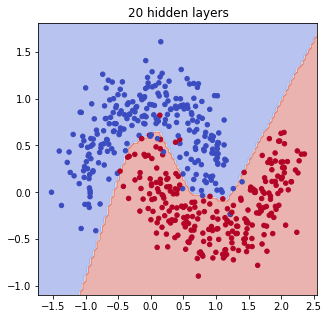

In [101]:
parameters = nn_fit(X,y,[2,100,1],learning_rate=1,num_iterations=2501,verbose=True)

y_test = nn_predict(X_test,parameters)
Y_test = y_test.reshape(X1_test.shape)
    
plt.figure(figsize=(5,5))
plt.contourf(X1_test, X2_test, Y_test,cmap=plt.cm.coolwarm,alpha=0.4)
plt.scatter(X1,X2,c=y,s=20,edgecolor=None,cmap=plt.cm.coolwarm)
plt.title("{} hidden layers".format(20))
plt.show()

**Test different number of hidden layer**

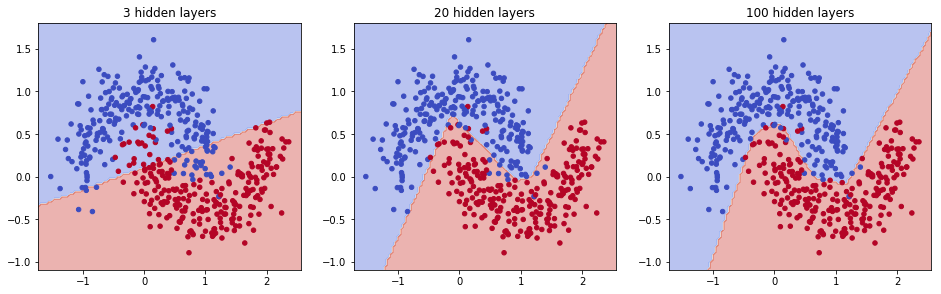

In [7]:
plt.figure(figsize=(16,10))
n_h_vec = [3,20,100]
for i in range(3):
    layer_dims = [2,n_h_vec[i],1]
    parameters = nn_fit(X,y,layer_dims,learning_rate=1,num_iterations=2000,verbose=False)
    y_test = nn_predict(X_test,parameters)
    
    Y_test = y_test.reshape(X1_test.shape)
    
    plt.subplot(2,3,i+1)
    plt.contourf(X1_test, X2_test, Y_test,cmap=plt.cm.coolwarm,alpha=0.4)
    plt.scatter(X1,X2,c=y,s=20,edgecolor=None,cmap=plt.cm.coolwarm)
    plt.title("{} hidden layers".format(n_h_vec[i]))
plt.show()

**Implementing everything using the Tensorflow - a neural network programming frame**

In [164]:
#
#
def tf_nn_fit(X_train,Y_train,n_h=10,learning_rate=1,num_iterations=2500,verbose=False):
    
    tf.reset_default_graph()
    #tf.set_random_seed(1) 
    
    # placehold X,Y
    n_sample = Y_train.shape[1]
    X = tf.placeholder(tf.float32,shape=[2,n_sample],name='X')
    Y = tf.placeholder(tf.float32,shape=[1,n_sample],name='Y')
    
    # initialize parameters
    W1 = tf.get_variable('W1',[n_h,2],initializer=tf.random_normal_initializer(stddev=1))
    # note: stddev of random_normal_initializer matters the final results
    # strategy: not to small (close to zeros, which not easy to break the symatric
    #           not too large, which slow the GD and easy to diverge
    b1 = tf.get_variable('b1',[n_h,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2',[1,n_h],initializer=tf.random_normal_initializer(stddev=1))
    b2 = tf.get_variable('b2',[1,1],initializer=tf.zeros_initializer())
        

    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z2,labels=Y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for i in range(0,num_iterations+1):
            _,cost_value = sess.run([optimizer,cost], feed_dict={X: X_train, Y: Y_train})
            
            if verbose and i % 500 == 0:
                print("Cost after iteration {}: {}".format(i, cost_value))
            
        #print(parameters)
        W1 = sess.run(W1)
        b1 = sess.run(b1)
        W2 = sess.run(W2)
        b2 = sess.run(b2)
        
    return W1,b1,W2,b2

In [155]:
def tf_nn_predict(X_test,W1,b1,W2,b2):
    tf.reset_default_graph()
    
    
    n_feature = X_test.shape[0]
    n_sample = X_test.shape[1]
    X = tf.placeholder(tf.float32,shape=[n_feature,n_sample],name='X')
    Y = tf.placeholder(tf.float32,shape=[1,n_sample],name='Y')
    
    W1 = tf.Variable(W1,name='W1')
    b1 = tf.Variable(b1,name='b1')
    W2 = tf.Variable(W2,name='W2')
    b2 = tf.Variable(b2,name='b2')
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.sigmoid(Z2)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        A2_result = sess.run(A2,feed_dict={X: X_test})
    
    y_pred_bool = A2_result > 0.5
    y_pred = 1*y_pred_bool
        
    return y_pred

Cost after iteration 0: 0.6536082625389099
Cost after iteration 500: 0.22839079797267914
Cost after iteration 1000: 0.2005893588066101
Cost after iteration 1500: 0.17027758061885834
Cost after iteration 2000: 0.1441679149866104
Cost after iteration 2500: 0.12619006633758545
Cost after iteration 3000: 0.11316598206758499
Cost after iteration 3500: 0.10424559563398361
Cost after iteration 4000: 0.09782475233078003
Cost after iteration 4500: 0.09299664199352264
Cost after iteration 5000: 0.08926701545715332


Text(0.5, 1.0, '20 hidden layers')

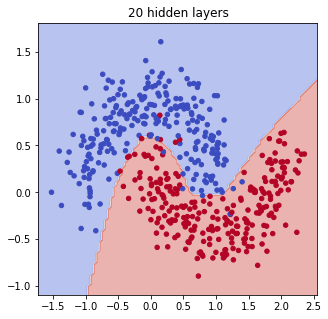

In [165]:
n_h = 20
W1,b1,W2,b2 = tf_nn_fit(X,y,n_h=n_h,learning_rate=0.05,num_iterations=5000,verbose=True)
y_test = tf_nn_predict(X_test,W1,b1,W2,b2)
Y_test = y_test.reshape(X1_test.shape)
    
plt.figure(figsize=(5,5))
plt.contourf(X1_test, X2_test, Y_test,cmap=plt.cm.coolwarm,alpha=0.4)
plt.scatter(X1,X2,c=y,s=20,edgecolor=None,cmap=plt.cm.coolwarm)
plt.title("{} hidden layers".format(n_h))
plt.show()